## Francisco Lozano | Preprocess | CSC 481 section 701
---

dataset: https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd version 1

Nasri, I., Karrouchi, M., Snoussi, H., Kassmi, K., Messaoudi, A. (2022). Detection and Prediction of Driver Drowsiness for the Prevention of Road Accidents Using Deep Neural Networks Techniques. In: Bennani, S., Lakhrissi, Y., Khaissidi, G., Mansouri, A., Khamlichi, Y. (eds) WITS 2020. Lecture Notes in Electrical Engineering, vol 745. Springer, Singapore. https://doi.org/10.1007/978-981-33-6893-4_6

We will begin by setting up our environment and helper functions

## Enviroment Setup

In [ ]:
# import libs
import cv2
import kagglehub
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
from enum import Enum
from google.colab import drive
from scipy import ndimage

In [ ]:
# mount google drive
drive.mount('/content/drive')
%cd /content/drive/My Drive
!git clone https://github.com/FranciscoLozCoding/csc481_Project.git
%cd csc481_Project

Mounted at /content/drive
/content/drive/My Drive
fatal: destination path 'csc481_Project' already exists and is not an empty directory.
/content/drive/My Drive/csc481_Project


## Helper Functions

In [ ]:
def apply_roberts(image):
    """
    Applies the Roberts edge detection operator to an input image.

    Parameters:
        image (numpy.ndarray): Grayscale input image for edge detection.

    Returns:
        numpy.ndarray: Normalized gradient magnitude image highlighting detected edges.
    """
    kernel_x = np.array([[1, 0], [0, -1]])
    kernel_y = np.array([[0, 1], [-1, 0]])
    roberts_x = ndimage.convolve(image, kernel_x)
    roberts_y = ndimage.convolve(image, kernel_y)
    magnitude = np.sqrt(roberts_x ** 2 + roberts_y ** 2)
    magnitude *= 255 / np.max(magnitude) #normalization
    return magnitude

def apply_sobel(image,depth=cv2.CV_64F,dx=1,dy=1,ksize=1):
    """
    Applies the Sobel edge detection operator to an input image.

    Parameters:
        image (numpy.ndarray): Grayscale input image for edge detection.
        depth (int): Desired depth of the output image; typically `cv2.CV_64F` to
                      retain high precision of gradient values.
        dx (int): Order of the derivative in the x direction. Setting to 1 detects
                  vertical edges; 0 means no derivative in x direction.
        dy (int): Order of the derivative in the y direction. Setting to 1 detects
                  horizontal edges; 0 means no derivative in y direction.
        ksize (int): Size of the Sobel kernel; typically 1, 3, 5, or 7, where larger
                      kernels provide smoother gradients but may reduce edge accuracy.

    Returns:
        numpy.ndarray: Normalized gradient magnitude image highlighting detected edges.
    """
    sobel_x = cv2.Sobel(image, cv2.CV_64F, dx, 0, ksize=ksize)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, dy, ksize=ksize)
    magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    magnitude *= 255 / np.max(magnitude) #normalization
    return magnitude

def apply_prewitt(image, mode="reflect"):
    """
    Applies the Prewitt edge detection operator to an input image.

    Parameters:
        image (numpy.ndarray): Grayscale input image for edge detection.
        mode (str): Border handling mode (e.g., 'reflect', 'constant'). Determines
                    how the edges of the image are treated during convolution.

    Returns:
        numpy.ndarray: Normalized gradient magnitude image highlighting detected edges.
    """
    prewitt_x = ndimage.prewitt(image, axis=0, mode=mode)
    prewitt_y = ndimage.prewitt(image, axis=1, mode=mode)
    magnitude = np.sqrt(prewitt_x ** 2 + prewitt_y ** 2)
    magnitude *= 255 / np.max(magnitude) #normalization
    return magnitude

def apply_canny(image, low_threshold=100, up_threshold=200):
    """
    Applies the Canny edge detection algorithm to an input image.

    Parameters:
        image (numpy.ndarray): Grayscale input image on which edges are to be detected.
        low_threshold (int): Lower threshold for the hysteresis procedure in edge detection.
        up_threshold (int): Upper threshold for the hysteresis procedure in edge detection.

    Returns:
        numpy.ndarray: Binary image with detected edges highlighted in white (255)
                       and non-edge areas in black (0).
    """
    return cv2.Canny(image, low_threshold, up_threshold)

def display_images(original, roberts, sobel, prewitt, canny, title=None):
    """
    Displays the original, Roberts, Sobel, Prewitt, and Canny edge detection results.
    """
    plt.figure(figsize=(12, 8))
    if title:
        plt.suptitle(title, fontsize=16)

    plt.subplot(2, 3, 1), plt.imshow(original, cmap='gray'), plt.title('Original')
    plt.subplot(2, 3, 2), plt.imshow(roberts, cmap='gray'), plt.title('Roberts')
    plt.subplot(2, 3, 3), plt.imshow(sobel, cmap='gray'), plt.title('Sobel')
    plt.subplot(2, 3, 4), plt.imshow(prewitt, cmap='gray'), plt.title('Prewitt')
    plt.subplot(2, 3, 5), plt.imshow(canny, cmap='gray'), plt.title('Canny')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the main title
    plt.show()

def imnoise(image, noise_type="gaussian", mean=0, var=0.1):
    """
    Add noise to an image.

    Parameters:
        image (ndarray): Input image (grayscale).
        noise_type (str): Type of noise to add ('gaussian', 'salt & pepper').
        mean (float): Mean value for Gaussian noise.
        var (float): Variance for Gaussian noise or proportion of noise for salt & pepper.

    Returns:
        ndarray: Noisy image.
    """
    if noise_type == "gaussian":
        # Generate Gaussian noise
        gauss = np.random.normal(mean, var**0.5, image.shape).astype(np.float32)
        noisy_image = cv2.add(image.astype(np.float32), gauss)  # Add noise to image

    elif noise_type == "salt & pepper":
        # Generate salt and pepper noise
        noisy_image = np.copy(image)
        s_vs_p = 0.5  # Salt vs Pepper ratio
        amount = var  # Proportion of image to replace with noise
        total_pixels = noisy_image.size
        num_salt = np.ceil(amount * total_pixels * s_vs_p)
        num_pepper = np.ceil(amount * total_pixels * (1. - s_vs_p))

        # Add Salt noise
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        noisy_image[coords[0], coords[1]] = 1  # Salt

        # Add Pepper noise
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        noisy_image[coords[0], coords[1]] = 0  # Pepper

    else:
        raise ValueError("Unsupported noise type. Choose from 'gaussian' & 'salt & pepper'.")

    # Clip values to be in valid range
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return noisy_image

def preprocess_image(image_name, selected_images, folder_path, output_folder_path, sobel_ksize):
  """
  Preprocess a single image by converting to grayscale and applying a Sobel filter (1 new image). If image is
  in selected images, add noise and apply sobel filter (3 new images).

  Parameters:
      image_name (str): the name of the image file.
      selected_images (set): a set of image names to add noise to.
      folder_path (str): the path to the folder containing the image.
      output_folder_path (str): the path to save the processed image.
      sobel_ksize (int): the kernel size for the Sobel filter.
  """
  # Convert image to grayscale
  img_path = os.path.join(folder_path, image_name)
  image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

  if image is None:
      print(f"Could not read image {img_path}")
      return

  # Apply Sobel filter to original image and save
  sobel_image = apply_sobel(image, ksize=sobel_ksize)
  sobel_image_path = os.path.join(output_folder_path, image_name)
  cv2.imwrite(sobel_image_path, sobel_image)

  # If selected add noise, apply sobel filter, and save
  if image_name in selected_images:
      # Add Gaussian noise
      gaussian_noisy_image = imnoise(image, noise_type="gaussian", mean=0, var=200)
      gaussian_noisy_image = np.clip(gaussian_noisy_image, 0, 255).astype(np.uint8)
      gaussian_noisy_image = apply_sobel(gaussian_noisy_image, ksize=sobel_ksize)
      gaussian_noisy_img_path = os.path.join(output_folder_path, f"noisy_gaussian_{image_name}")
      cv2.imwrite(gaussian_noisy_img_path, gaussian_noisy_image)

      # Add salt-and-pepper noise
      sp_noisy_image = imnoise(image, noise_type="salt & pepper")
      sp_noisy_image = np.clip(sp_noisy_image, 0, 255).astype(np.uint8)
      sp_noisy_image = apply_sobel(sp_noisy_image, ksize=sobel_ksize)
      sp_noisy_img_path = os.path.join(output_folder_path, f"noisy_saltpepper_{image_name}")
      cv2.imwrite(sp_noisy_img_path, sp_noisy_image)

  return

def preprocess(path, folders, output_path, noisy_copies, sobel_ksize):
  """
  Preprocess multiple images by converting to grayscale, adding noise, and applying a Sobel filter.

  Parameters:
      path (str): the dataset folder path.
      folders (list): the folders in the dataset.
      output_path (str): the folder path to save the preprocessed dataset.
      noisy_copies (int): the number of noisy copies to create per folder.
      sobel_ksize (int): the kernel size for the Sobel filter.
  """
  # Ensure output directories are created
  os.makedirs(output_path, exist_ok=True)

  # Process each folder
  for folder in folders:
      folder_path = os.path.join(path, folder)
      output_folder_path = os.path.join(output_path, folder)
      os.makedirs(output_folder_path, exist_ok=True)

      images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

      # Randomly select images for noise addition
      selected_images = set(random.sample(images, min(noisy_copies, len(images))))

      # Use ThreadPoolExecutor to process images in parallel
      with ThreadPoolExecutor() as executor:
          for image_name in images:
              executor.submit(preprocess_image, image_name, selected_images,
                              folder_path, output_folder_path, sobel_ksize)

  print("All images have been preprocessed and saved to:", output_path)


## Loading an Example Image

First we will load in a drowsy person image and turn it into grayscale for easier processing.

In [ ]:
#read image
D_IMAGE_PATH = 'data/raw/drowsy.png'
D_IMAGE = cv2.imread(D_IMAGE_PATH)

# display original image
plt.axis('off')  # Hide axes
plt.imshow(cv2.cvtColor(D_IMAGE, cv2.COLOR_BGR2RGB))

In [ ]:
# Convert to grayscale
d_gray_image = cv2.cvtColor(D_IMAGE, cv2.COLOR_BGR2GRAY)

# Display the grayscale image
plt.axis('off')  # Hide axes
plt.imshow(d_gray_image, cmap='gray')

Next we will load in a non-drowsy person image and turn it into grayscale for easier processing.

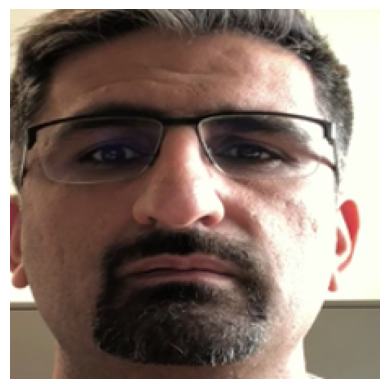

In [ ]:
#read image
ND_IMAGE_PATH = 'data/raw/non_drowsy.png'
ND_IMAGE = cv2.imread(ND_IMAGE_PATH)

# display original image
plt.axis('off')  # Hide axes
plt.imshow(cv2.cvtColor(ND_IMAGE, cv2.COLOR_BGR2RGB))

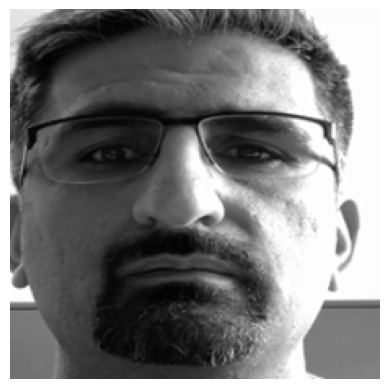

In [ ]:
# Convert to grayscale
nd_gray_image = cv2.cvtColor(ND_IMAGE, cv2.COLOR_BGR2GRAY)

# Display the grayscale image
plt.axis('off')  # Hide axes
plt.imshow(nd_gray_image, cmap='gray')

Now that we have example images, we can play around with filters to see if any make the features around the eye stand out more

## Finding a Filter

I will be using [eye aspect ratio (EAR)](http://vision.fe.uni-lj.si/cvww2016/proceedings/papers/05.pdf) so I need the filter to make the eye features more visible. More specifically the Eyelid, Pupil, Sclera, and Iris.

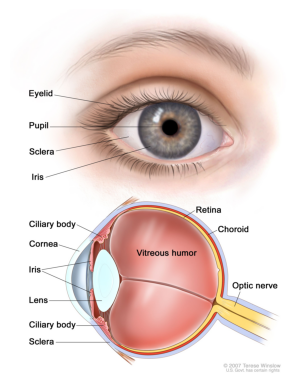

In [ ]:
#read image
EYE_IMAGE = cv2.imread('images/eye.jpg')

# display original image
plt.axis('off')  # Hide axes
plt.imshow(cv2.cvtColor(EYE_IMAGE, cv2.COLOR_BGR2RGB))

### Drowsy Image

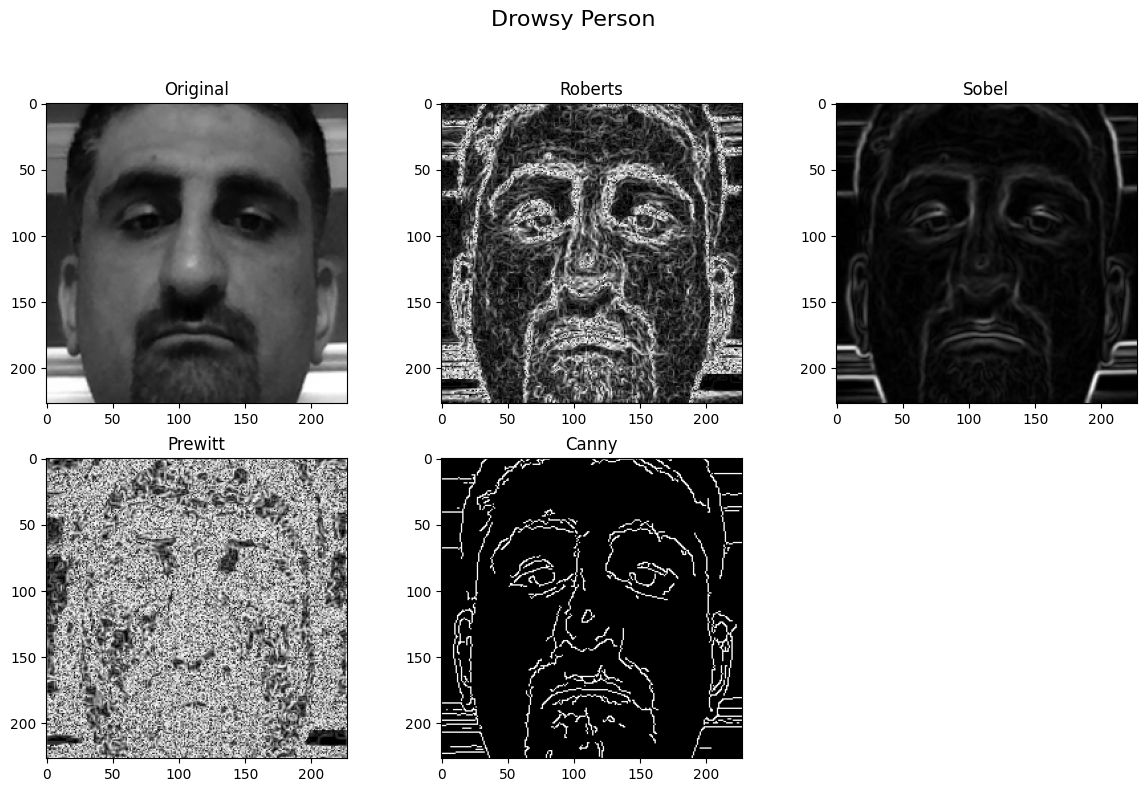

In [ ]:
# Apply each edge detection function
roberts_edges = apply_roberts(d_gray_image)
#ksize=7 showed best results
sobel_edges = apply_sobel(d_gray_image, ksize=7)
#constant = The input is extended by filling all values beyond the edge with 0
prewitt_edges = apply_prewitt(d_gray_image,mode="constant")
#threshold 50,100 gave the best results
canny_edges = apply_canny(d_gray_image, low_threshold=50, up_threshold=100)
# Display results
display_images(d_gray_image, roberts_edges, sobel_edges, prewitt_edges, canny_edges, title="Drowsy Person")

For detecting droopy eyelids as an indication of drowsiness while driving, the **Sobel operator** provided the best performance, especially when using a larger `ksize`. Increasing the `ksize` in Sobel creates smoother gradients, which is ideal for highlighting the gradual droop of the eyelids rather than sharply defined edges. Since my focus is on showing the eyelids covering the pupil, precise edge sharpness is less critical, and smoother transitions are more effective.

On the other hand, the **Roberts** and **Prewitt** operators tended to detect excessive edges, introducing significant noise in the image. This added noise made it harder to isolate drooping eyelids effectively. The **Prewitt** operator, in particular, resulted in a considerable amount of noise, though my function implementation appears correct.

The **Canny operator** also performed relatively well, showing droopy eyelids effectively after adjusting the lower and upper thresholds. However, Sobel remains the most suitable in this case due to its ability to capture smoother gradient transitions, which align well with the subtle changes I want to detect.

### Non-Drowsy Image

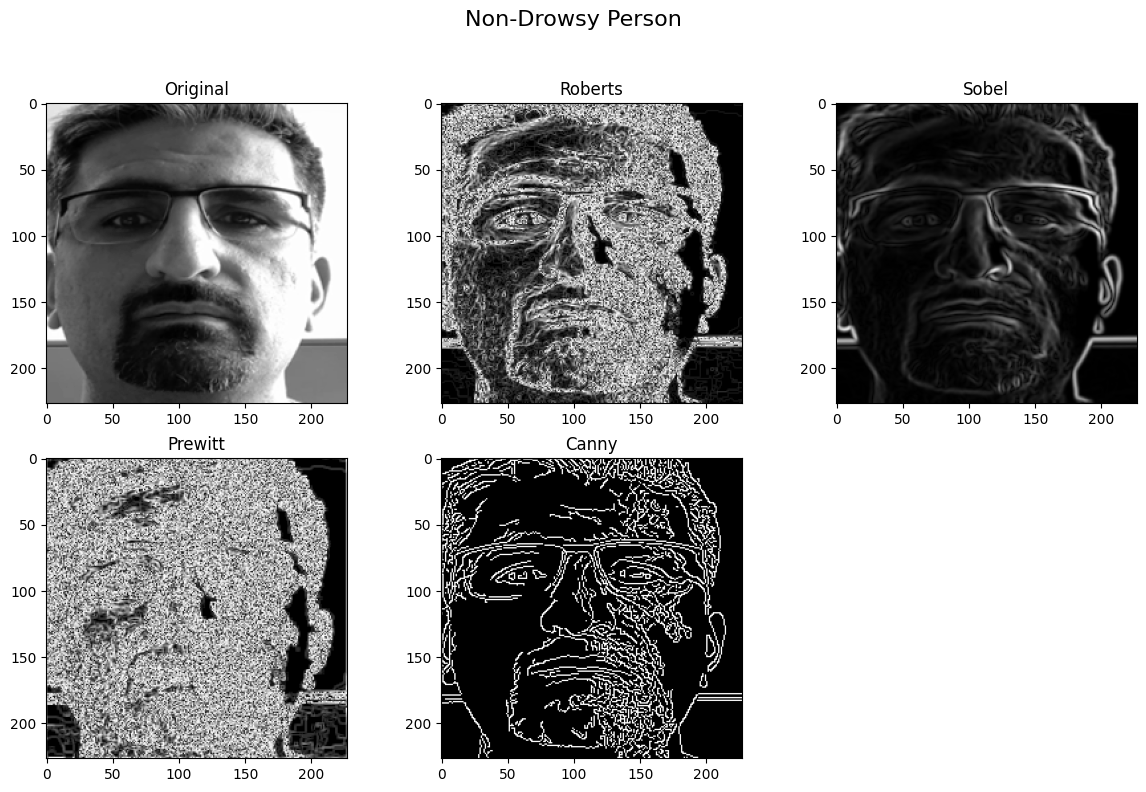

In [ ]:
# Apply each edge detection function
roberts_edges = apply_roberts(nd_gray_image)
#ksize=7 showed best results
sobel_edges = apply_sobel(nd_gray_image, ksize=7)
#constant = The input is extended by filling all values beyond the edge with 0
prewitt_edges = apply_prewitt(nd_gray_image,mode="constant")
#threshold 50,100 gave the best results
canny_edges = apply_canny(nd_gray_image, low_threshold=50, up_threshold=100)
# Display results
display_images(nd_gray_image, roberts_edges, sobel_edges, prewitt_edges, canny_edges, title="Non-Drowsy Person")

To detect open (non-drowsy) eyelids, I found that the **Sobel operator** provided the best results. My goal is to show the eyelids in a way that keeps the pupil visible, along with the Sclera (the white part of the eye). Since clear, sharp edges aren't as important for this, a smoother gradient transition works better, making the Sobel operator ideal.

In this image, the **Canny operator** did not perform well because of sunlight shining on the person's face and the presence of glasses. These factors affected the Canny results, creating noise and inconsistent edges. Given that similar lighting conditions or eyewear may appear in other images, the Canny operator is not a suitable choice for my use case. Sobel remains the preferred option because it effectively captures gradual transitions, aligning well with the subtle changes I want to highlight.

### Adding Noise to Drowsy Image

Next, I will add noise before the filter is applied simulating a bad image capture of the drowsy driver.

#### Gaussian Noise

In [ ]:
# Add Gaussian noise
noisy_d_image_gaussian = imnoise(d_gray_image, noise_type='gaussian', mean=0, var=200)

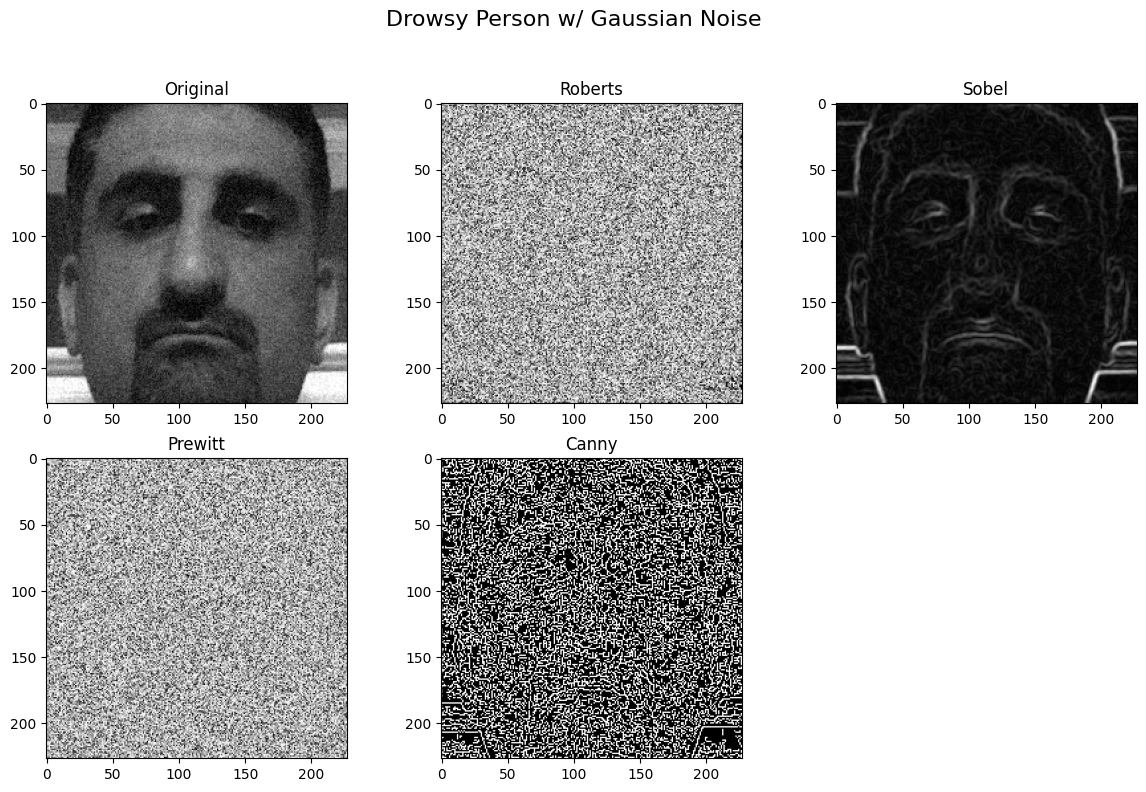

In [ ]:
# Apply each edge detection function
roberts_edges = apply_roberts(noisy_d_image_gaussian)
#ksize=7 showed best results
sobel_edges = apply_sobel(noisy_d_image_gaussian, ksize=7)
#constant = The input is extended by filling all values beyond the edge with 0
prewitt_edges = apply_prewitt(noisy_d_image_gaussian,mode="constant")
#threshold 50,100 gave the best results
canny_edges = apply_canny(noisy_d_image_gaussian, low_threshold=50, up_threshold=100)
# Display results
display_images(noisy_d_image_gaussian, roberts_edges, sobel_edges, prewitt_edges, canny_edges, title="Drowsy Person w/ Gaussian Noise")

The **Sobel operator** again did well avoiding the noise and smoothing the images, so this filter remains the best one. The other filters failed to do the same showing again why it would not be good to pick these filters.

#### Salt and Pepper noise

In [ ]:
# Add Salt and Pepper noise
noisy_d_image_sp = imnoise(d_gray_image, noise_type='salt & pepper', var=0.05)

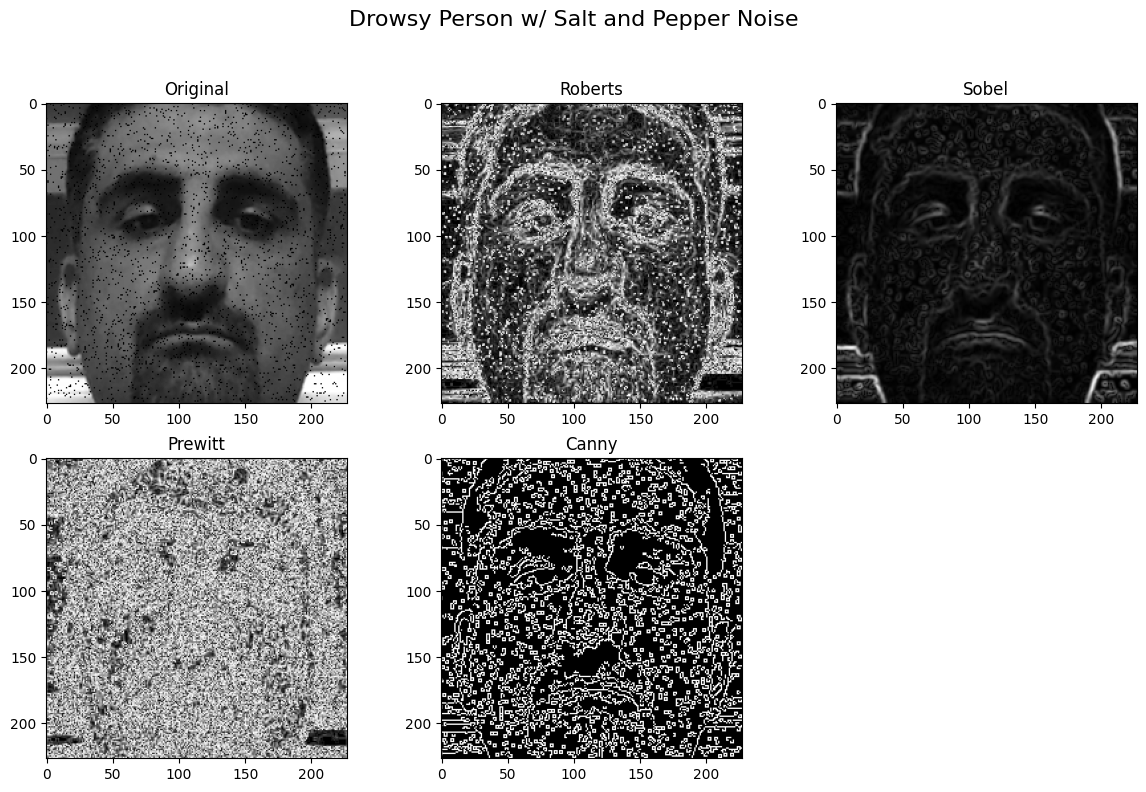

In [ ]:
# Apply each edge detection function
roberts_edges = apply_roberts(noisy_d_image_sp)
#ksize=7 showed best results
sobel_edges = apply_sobel(noisy_d_image_sp, ksize=7)
#constant = The input is extended by filling all values beyond the edge with 0
prewitt_edges = apply_prewitt(noisy_d_image_sp,mode="constant")
#threshold 50,100 gave the best results
canny_edges = apply_canny(noisy_d_image_sp, low_threshold=50, up_threshold=100)
# Display results
display_images(noisy_d_image_sp, roberts_edges, sobel_edges, prewitt_edges, canny_edges, title="Drowsy Person w/ Salt and Pepper Noise")

The **Sobel operator** again did well avoiding the noise and smoothing the images, so this filter remains the best one. The other filters failed to do the same showing again why it would not be good to pick these filters.

### Adding Noise to Non-Drowsy Image

Next, I will add noise before the filter is applied simulating a bad image capture of the non drowsy driver.

#### Gaussian Noise

In [ ]:
# Add Gaussian noise
noisy_nd_image_gaussian = imnoise(nd_gray_image, noise_type='gaussian', mean=0, var=200)

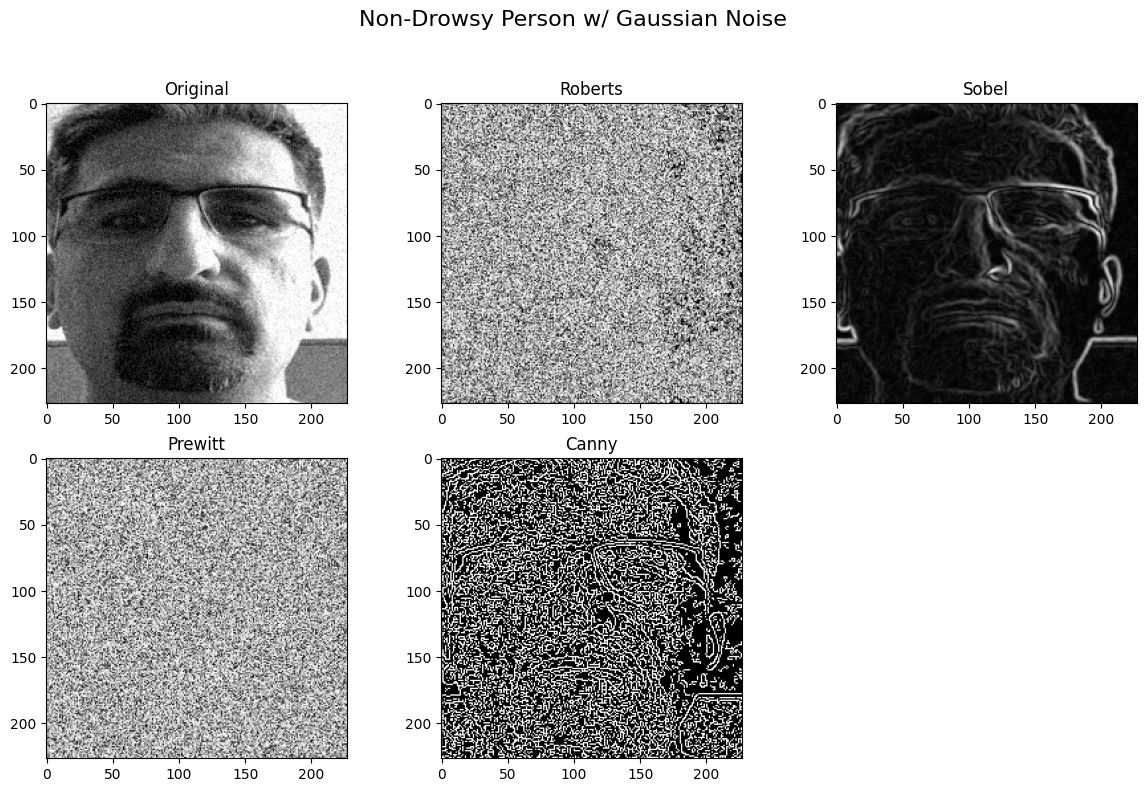

In [ ]:
# Apply each edge detection function
roberts_edges = apply_roberts(noisy_nd_image_gaussian)
#ksize=7 showed best results
sobel_edges = apply_sobel(noisy_nd_image_gaussian, ksize=7)
#constant = The input is extended by filling all values beyond the edge with 0
prewitt_edges = apply_prewitt(noisy_nd_image_gaussian,mode="constant")
#threshold 50,100 gave the best results
canny_edges = apply_canny(noisy_nd_image_gaussian, low_threshold=50, up_threshold=100)
# Display results
display_images(noisy_nd_image_gaussian, roberts_edges, sobel_edges, prewitt_edges, canny_edges, title="Non-Drowsy Person w/ Gaussian Noise")

The **Sobel operator** again did well avoiding the noise and smoothing the images, so this filter remains the best one. The other filters failed to do the same showing again why it would not be good to pick these filters.

#### Salt and Pepper noise

In [ ]:
# Add Salt and Pepper noise
noisy_nd_image_sp = imnoise(nd_gray_image, noise_type='salt & pepper', var=0.05)

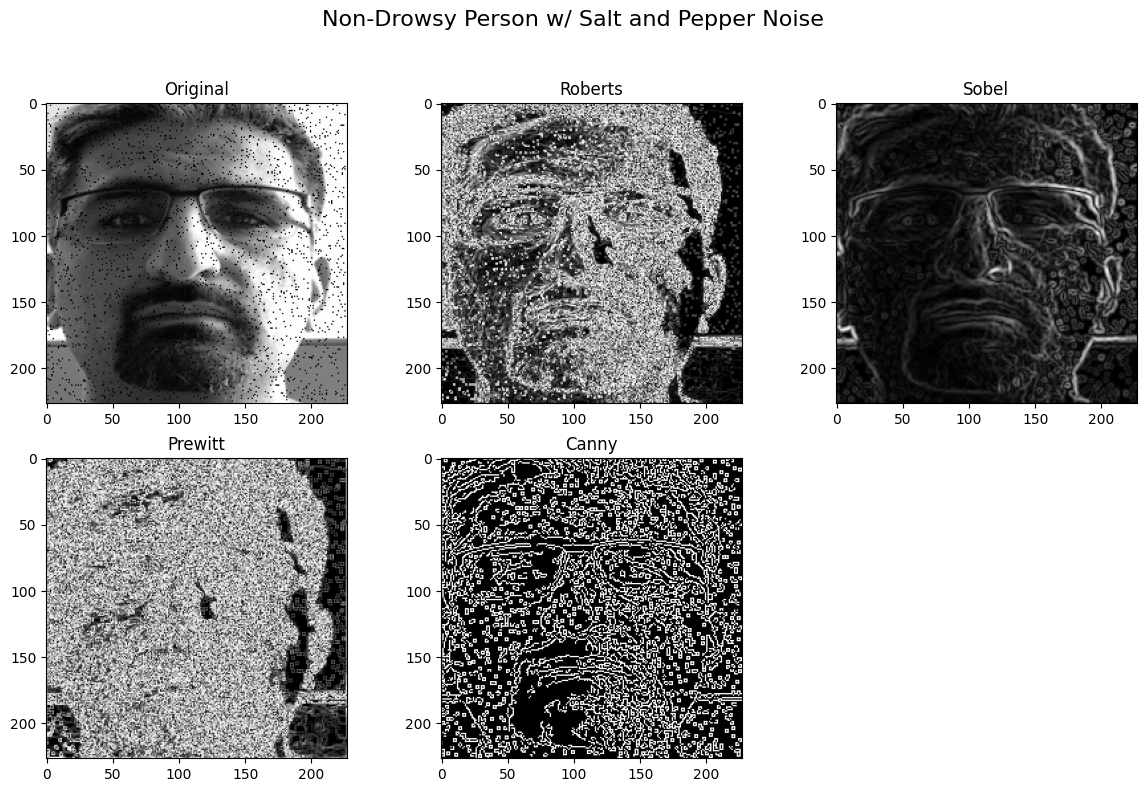

In [ ]:
# Apply each edge detection function
roberts_edges = apply_roberts(noisy_nd_image_sp)
#ksize=7 showed best results
sobel_edges = apply_sobel(noisy_nd_image_sp, ksize=7)
#constant = The input is extended by filling all values beyond the edge with 0
prewitt_edges = apply_prewitt(noisy_nd_image_sp,mode="constant")
#threshold 50,100 gave the best results
canny_edges = apply_canny(noisy_nd_image_sp, low_threshold=50, up_threshold=100)
# Display results
display_images(noisy_nd_image_sp, roberts_edges, sobel_edges, prewitt_edges, canny_edges, title="Non-Drowsy Person w/ Salt and Pepper Noise")

The **Sobel operator** again did well avoiding the noise and smoothing the images, so this filter remains the best one. The other filters failed to do the same showing again why it would not be good to pick these filters.

### My Findings

Based on my results, the **Sobel operator** was the most effective at enhancing eye features—specifically the eyelid, pupil, sclera, and iris. It consistently reduced noise while keeping these features clear, even in images with varying noise levels. The operator was tested on both drowsy and non-drowsy individuals, confirming its reliability across different conditions.

## Preprocessing Images

Now that I know what filter will work best, I can preprocess all images. I will also add noisy images to better train future models.

In [ ]:
path = kagglehub.dataset_download("ismailnasri20/driver-drowsiness-dataset-ddd")
path = path + "/Driver Drowsiness Dataset (DDD)" # folder with drowsy and non drowsy folders
print("Path to dataset files:", path)

100%|██████████| 2.58G/2.58G [00:25<00:00, 110MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/versions/1/Driver Drowsiness Dataset (DDD)


In [ ]:
os.listdir(path)

['Non Drowsy', 'Drowsy']

In [ ]:
preprocess(path, ["Drowsy", "Non Drowsy"], "/content/dd_dataset", 5000, 7)

All images have been preprocessed and saved to: /content/dd_dataset
